# Introduction

This notebook attempts to improve the score from `roger_exploration_scale_pos_weight.ipynb` of 0.69390 (model `10906675_xgb_es_spw.joblib`) by reducing the overfitting by tuning the number of components in the PCA transformation. The current `n_components` of 8 shows [overfitting](#Overfitting).

## Summary
* using only 1 pca component reduced the overfitting the most, see [result](#Result)
* but the [results of test AUC](#results-of-test-AUC) was not an improvement; 0.67760

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

from src.data.make_dataset import load_sets, save_sets, save_predictions
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie, create_feature_importance_df, plot_feature_importances


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [5]:
competition = os.environ['COMPETITION']

# Set up directories

In [6]:
project_dir = Path.cwd().parent.parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [7]:
X_train, X_val, y_train, y_val, X_test = load_sets(interim_data_dir)
X_train_lim, X_val_lim, y_train_lim, y_val_lim, X_test_lim = load_sets(interim_data_dir, suffix='top_8_features')
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

# Baseline

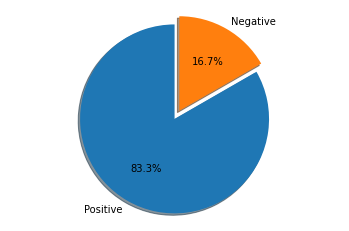

In [8]:
plot_pie(y_train)

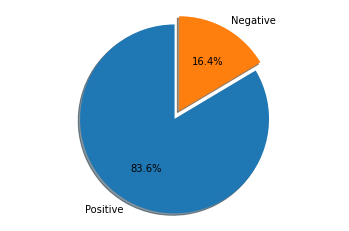

In [9]:
plot_pie(y_val)

## Baseline Score

The baseline is simply the best from the previous attempt of 0.69051.

# Load best model

The best model so far is `randomised_xgb.joblib` with a test AUC of 0.69051.

In [10]:
base_model = load(models_dir / '10906675_xgb_es_spw.joblib')

In [11]:
base_model

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.590700201239684,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.020933095390929836,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=184,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=0.5500000000000002,
                            

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  54 1014]
 [  12 5320]]
Accuracy:  0.8396875
AUC:  0.7836622076867532
              precision    recall  f1-score   support

           0       0.82      0.05      0.10      1068
           1       0.84      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.83      0.52      0.50      6400
weighted avg       0.84      0.84      0.78      6400



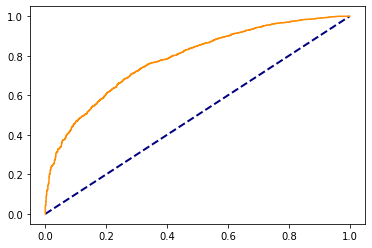

In [15]:
classification_reports(base_model, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   5  258]
 [   5 1332]]
Accuracy:  0.835625
AUC:  0.6990709010297727
              precision    recall  f1-score   support

           0       0.50      0.02      0.04       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.67      0.51      0.47      1600
weighted avg       0.78      0.84      0.77      1600



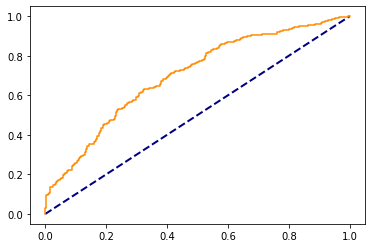

In [16]:
classification_reports(base_model, X_val, y_val)

## Overfitting

The training AUC is 0.784, while the validation AUC is 0.699; a difference of 0.085. This shows that the model is overfit.

# Reduce `n_components`

The latest results show around 0.07 difference in the training and validation AUC, indicating overfitting. Reducing the number of features should mitigate this.

In [14]:
base_model_params = base_model['classifier'].get_params()
base_model_params

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.590700201239684,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.020933095390929836,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 184,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 0.5500000000000002,
 'subsample': 0.6028987933998539,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss'}

In [28]:
model_list = []
n_components_list = []
train_auc_list = []
val_auc_list = []

for n_components in range(1, 8):
    clf = xgb.XGBClassifier(**base_model_params)
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ])
    
    pipe.fit(X_train)
    X_train_trans = pipe.transform(X_train)
    X_val_trans = pipe.transform(X_val)
       
    fit_params = {'eval_set': [(X_val_trans, y_val)],
                  'eval_metric': 'auc',
                  'early_stopping_rounds': 10,
                  'verbose': False}
    
    clf.fit(X_train_trans, y_train, **fit_params)
    
    train_probs = clf.predict_proba(X_train_trans)[:, 1]
    val_probs = clf.predict_proba(X_val_trans)[:, 1]
    train_auc = roc_auc_score(y_train, train_probs)
    val_auc = roc_auc_score(y_val, val_probs)
    
    model_list.append(clf)
    n_components_list.append(n_components)
    train_auc_list.append(train_auc)
    val_auc_list.append(val_auc)

## Result

In [29]:
result_df = (
    pd.DataFrame({'n_components': n_components_list,
                  'train_auc': train_auc_list,
                  'val_auc': val_auc_list})
    .assign(diff_auc=lambda x: x.train_auc - x.val_auc,
            ratio_auc=lambda x: 1 - x.val_auc/x.train_auc)
)

result_df

,n_components,train_auc,val_auc,diff_auc,ratio_auc
0,1,0.685417,0.684705,0.000712,0.001039
1,2,0.706201,0.681139,0.025063,0.035489
2,3,0.706482,0.681986,0.024495,0.034672
3,4,0.719245,0.690686,0.028559,0.039707
4,5,0.708047,0.677511,0.030536,0.043127
5,6,0.743682,0.682764,0.060918,0.081914
6,7,0.769762,0.693975,0.075788,0.098456


Using `n_components` of 1 by far results in the least amount of overfitting.

## Retrain model

In [30]:
best_n_components = 1

In [35]:
clf = xgb.XGBClassifier(**base_model_params)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=best_n_components))
])

pipe.fit(X_train)
X_val_trans = pipe.transform(X_val)

pipe.steps.append(('classifier', clf))

fit_params = {'classifier__eval_set': [(X_val_trans, y_val)],
              'classifier__eval_metric': 'auc',
              'classifier__early_stopping_rounds': 10,
              'classifier__verbose': False}

pipe.fit(X_train, y_train, **fit_params)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=1)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.590700201239684,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.020933095390929836,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=184,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=0.5500000000000002,
                            

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  55 1013]
 [  44 5288]]
Accuracy:  0.83484375
AUC:  0.6854172286049041
              precision    recall  f1-score   support

           0       0.56      0.05      0.09      1068
           1       0.84      0.99      0.91      5332

    accuracy                           0.83      6400
   macro avg       0.70      0.52      0.50      6400
weighted avg       0.79      0.83      0.77      6400



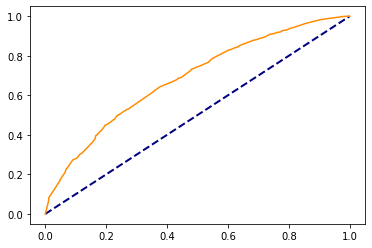

In [37]:
classification_reports(pipe, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  12  251]
 [  17 1320]]
Accuracy:  0.8325
AUC:  0.6847049890368028
              precision    recall  f1-score   support

           0       0.41      0.05      0.08       263
           1       0.84      0.99      0.91      1337

    accuracy                           0.83      1600
   macro avg       0.63      0.52      0.50      1600
weighted avg       0.77      0.83      0.77      1600



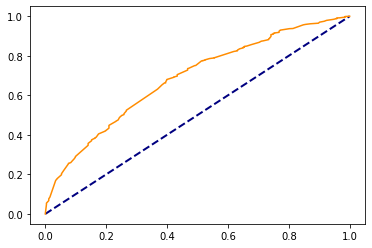

In [38]:
classification_reports(pipe, X_val, y_val)

## Save model

In [44]:
model_name = '10906675_xgb_es_spw_1_comp'
path = models_dir / model_name
path

WindowsPath('D:/Projects/assignment_1/models/10906675_xgb_es_spw_1_comp')

In [47]:
dump(pipe, path.with_suffix('.joblib'))

['D:\\Projects\\assignment_1\\models\\10906675_xgb_es_spw_1_comp.joblib']

# Prediction on test set

In [42]:
probs = pipe.predict_proba(X_test)[:, 1]

In [35]:
probs

array([0.65319955, 0.65564203, 0.72314936, ..., 0.60709983, 0.72595614,
       0.6344749 ], dtype=float32)

In [48]:
path = processed_data_dir / f'probs_{model_name}.csv'
save_predictions(probs, 'TARGET_5Yrs', test_id, path)

## Submit predictions

# Results of test AUC

The test AUC is 0.67760.